# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

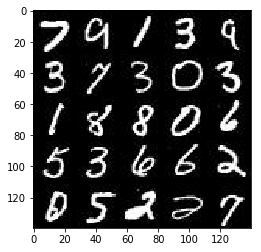

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

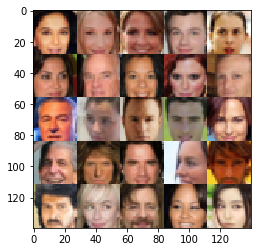

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_input_images')
    tensor_z_data = tf.placeholder(tf.float32, (None, z_dim), name='tensor_z_data')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return real_input_images, tensor_z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """    
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(0.2 * x1, x1)
        # 16x16x32
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(0.2 * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(0.2 * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [14]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    # TODO: Implement Function
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        alpha=0.2
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512) 
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))  
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)

        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)

        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    _, image_width, image_height, image_channels = data_shape
    real_input, z_input, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(real_input, z_input, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    losses = []
    n_images = 25
    print_at_step= 10
    show_at_step = 100
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                steps += 1
                batch_images *= 2.0
                
                # Sample random noise for G
                z_sample = np.random.uniform(-1, 1, (batch_size, z_dim)) 
                
                # Run optimizers                
                _ = sess.run(d_opt, feed_dict={real_input: batch_images, z_input: z_sample})
                _ = sess.run(g_opt, feed_dict={z_input: z_sample, real_input: batch_images})
                
                if steps % print_at_step == 0:
                    train_loss_d = d_loss.eval({z_input: z_sample, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_sample})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.3f}...".format(train_loss_d),
                          "Generator Loss: {:.3f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_at_step == 0:
                    show_generator_output(sess, n_images, z_input, image_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [ ]:
batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.278... Generator Loss: 4.037
Epoch 1/1... Discriminator Loss: 0.752... Generator Loss: 1.192
Epoch 1/1... Discriminator Loss: 2.798... Generator Loss: 0.140
Epoch 1/1... Discriminator Loss: 1.274... Generator Loss: 0.664
Epoch 1/1... Discriminator Loss: 0.816... Generator Loss: 1.979
Epoch 1/1... Discriminator Loss: 0.784... Generator Loss: 1.196
Epoch 1/1... Discriminator Loss: 0.788... Generator Loss: 1.995
Epoch 1/1... Discriminator Loss: 1.569... Generator Loss: 3.860
Epoch 1/1... Discriminator Loss: 1.030... Generator Loss: 0.934
Epoch 1/1... Discriminator Loss: 1.170... Generator Loss: 0.631


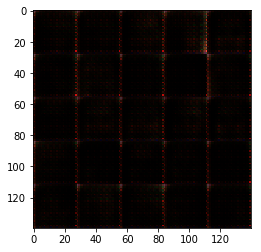

Epoch 1/1... Discriminator Loss: 1.725... Generator Loss: 0.327
Epoch 1/1... Discriminator Loss: 1.725... Generator Loss: 1.256
Epoch 1/1... Discriminator Loss: 1.452... Generator Loss: 1.977
Epoch 1/1... Discriminator Loss: 1.468... Generator Loss: 0.492
Epoch 1/1... Discriminator Loss: 1.336... Generator Loss: 1.902
Epoch 1/1... Discriminator Loss: 0.831... Generator Loss: 1.833
Epoch 1/1... Discriminator Loss: 1.506... Generator Loss: 0.577
Epoch 1/1... Discriminator Loss: 1.294... Generator Loss: 0.668
Epoch 1/1... Discriminator Loss: 1.594... Generator Loss: 0.389
Epoch 1/1... Discriminator Loss: 0.952... Generator Loss: 1.658


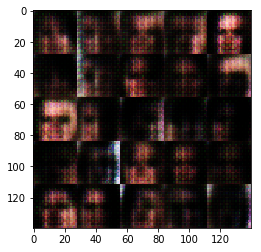

Epoch 1/1... Discriminator Loss: 1.509... Generator Loss: 0.487
Epoch 1/1... Discriminator Loss: 1.076... Generator Loss: 1.207
Epoch 1/1... Discriminator Loss: 0.832... Generator Loss: 1.079
Epoch 1/1... Discriminator Loss: 1.171... Generator Loss: 0.694
Epoch 1/1... Discriminator Loss: 2.050... Generator Loss: 3.522
Epoch 1/1... Discriminator Loss: 1.293... Generator Loss: 0.577
Epoch 1/1... Discriminator Loss: 1.840... Generator Loss: 0.252
Epoch 1/1... Discriminator Loss: 0.810... Generator Loss: 2.743
Epoch 1/1... Discriminator Loss: 1.020... Generator Loss: 1.310
Epoch 1/1... Discriminator Loss: 1.196... Generator Loss: 1.298


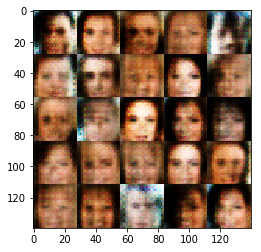

Epoch 1/1... Discriminator Loss: 1.048... Generator Loss: 0.909
Epoch 1/1... Discriminator Loss: 0.869... Generator Loss: 0.972
Epoch 1/1... Discriminator Loss: 1.339... Generator Loss: 0.457
Epoch 1/1... Discriminator Loss: 1.069... Generator Loss: 0.641
Epoch 1/1... Discriminator Loss: 1.515... Generator Loss: 0.338
Epoch 1/1... Discriminator Loss: 1.149... Generator Loss: 0.761
Epoch 1/1... Discriminator Loss: 0.434... Generator Loss: 1.576
Epoch 1/1... Discriminator Loss: 0.658... Generator Loss: 1.421
Epoch 1/1... Discriminator Loss: 0.796... Generator Loss: 4.322
Epoch 1/1... Discriminator Loss: 0.235... Generator Loss: 4.014


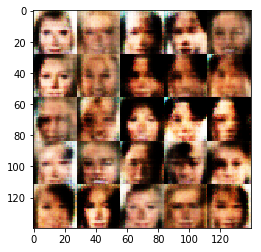

Epoch 1/1... Discriminator Loss: 0.505... Generator Loss: 1.598
Epoch 1/1... Discriminator Loss: 1.667... Generator Loss: 4.544
Epoch 1/1... Discriminator Loss: 1.849... Generator Loss: 0.225
Epoch 1/1... Discriminator Loss: 0.799... Generator Loss: 4.558
Epoch 1/1... Discriminator Loss: 0.321... Generator Loss: 3.308
Epoch 1/1... Discriminator Loss: 1.846... Generator Loss: 0.233
Epoch 1/1... Discriminator Loss: 0.743... Generator Loss: 1.986
Epoch 1/1... Discriminator Loss: 0.659... Generator Loss: 2.379
Epoch 1/1... Discriminator Loss: 0.356... Generator Loss: 2.036
Epoch 1/1... Discriminator Loss: 1.124... Generator Loss: 3.369


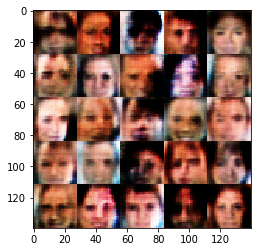

Epoch 1/1... Discriminator Loss: 0.504... Generator Loss: 1.525
Epoch 1/1... Discriminator Loss: 0.771... Generator Loss: 2.142
Epoch 1/1... Discriminator Loss: 0.685... Generator Loss: 1.575
Epoch 1/1... Discriminator Loss: 0.754... Generator Loss: 0.885
Epoch 1/1... Discriminator Loss: 0.481... Generator Loss: 2.155
Epoch 1/1... Discriminator Loss: 0.260... Generator Loss: 4.498
Epoch 1/1... Discriminator Loss: 1.104... Generator Loss: 4.922
Epoch 1/1... Discriminator Loss: 0.330... Generator Loss: 2.399
Epoch 1/1... Discriminator Loss: 0.482... Generator Loss: 1.951
Epoch 1/1... Discriminator Loss: 1.015... Generator Loss: 3.759


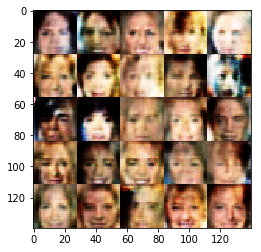

Epoch 1/1... Discriminator Loss: 0.619... Generator Loss: 1.184
Epoch 1/1... Discriminator Loss: 1.026... Generator Loss: 2.416
Epoch 1/1... Discriminator Loss: 0.337... Generator Loss: 1.882
Epoch 1/1... Discriminator Loss: 1.211... Generator Loss: 0.459
Epoch 1/1... Discriminator Loss: 0.782... Generator Loss: 0.928
Epoch 1/1... Discriminator Loss: 1.033... Generator Loss: 3.785
Epoch 1/1... Discriminator Loss: 1.549... Generator Loss: 0.319
Epoch 1/1... Discriminator Loss: 1.271... Generator Loss: 0.427
Epoch 1/1... Discriminator Loss: 0.523... Generator Loss: 3.022
Epoch 1/1... Discriminator Loss: 0.590... Generator Loss: 1.199


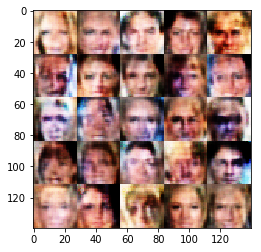

Epoch 1/1... Discriminator Loss: 1.014... Generator Loss: 1.206
Epoch 1/1... Discriminator Loss: 0.629... Generator Loss: 1.891
Epoch 1/1... Discriminator Loss: 0.679... Generator Loss: 2.066
Epoch 1/1... Discriminator Loss: 0.517... Generator Loss: 1.613
Epoch 1/1... Discriminator Loss: 0.424... Generator Loss: 1.435
Epoch 1/1... Discriminator Loss: 1.254... Generator Loss: 1.522
Epoch 1/1... Discriminator Loss: 0.642... Generator Loss: 1.030
Epoch 1/1... Discriminator Loss: 0.234... Generator Loss: 2.943
Epoch 1/1... Discriminator Loss: 0.797... Generator Loss: 3.073
Epoch 1/1... Discriminator Loss: 0.807... Generator Loss: 1.686


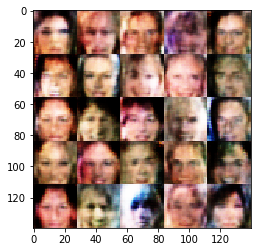

Epoch 1/1... Discriminator Loss: 0.228... Generator Loss: 2.326
Epoch 1/1... Discriminator Loss: 0.380... Generator Loss: 2.174
Epoch 1/1... Discriminator Loss: 0.640... Generator Loss: 1.629
Epoch 1/1... Discriminator Loss: 0.399... Generator Loss: 1.838
Epoch 1/1... Discriminator Loss: 0.999... Generator Loss: 1.495
Epoch 1/1... Discriminator Loss: 0.714... Generator Loss: 0.962
Epoch 1/1... Discriminator Loss: 0.286... Generator Loss: 2.607
Epoch 1/1... Discriminator Loss: 0.397... Generator Loss: 4.729
Epoch 1/1... Discriminator Loss: 0.689... Generator Loss: 1.731
Epoch 1/1... Discriminator Loss: 0.716... Generator Loss: 0.833


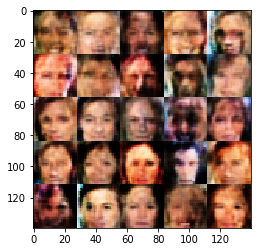

Epoch 1/1... Discriminator Loss: 1.788... Generator Loss: 0.281
Epoch 1/1... Discriminator Loss: 0.468... Generator Loss: 3.245
Epoch 1/1... Discriminator Loss: 0.292... Generator Loss: 1.965
Epoch 1/1... Discriminator Loss: 0.643... Generator Loss: 3.207
Epoch 1/1... Discriminator Loss: 0.662... Generator Loss: 1.019
Epoch 1/1... Discriminator Loss: 0.620... Generator Loss: 1.278
Epoch 1/1... Discriminator Loss: 1.128... Generator Loss: 0.553
Epoch 1/1... Discriminator Loss: 0.764... Generator Loss: 0.908
Epoch 1/1... Discriminator Loss: 0.311... Generator Loss: 2.033
Epoch 1/1... Discriminator Loss: 0.595... Generator Loss: 1.014


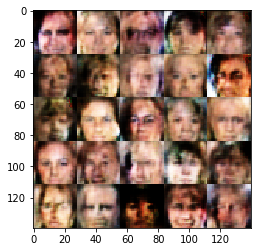

Epoch 1/1... Discriminator Loss: 0.161... Generator Loss: 3.534
Epoch 1/1... Discriminator Loss: 1.199... Generator Loss: 0.454
Epoch 1/1... Discriminator Loss: 1.017... Generator Loss: 0.588
Epoch 1/1... Discriminator Loss: 0.264... Generator Loss: 2.289
Epoch 1/1... Discriminator Loss: 0.694... Generator Loss: 0.909
Epoch 1/1... Discriminator Loss: 0.550... Generator Loss: 2.522
Epoch 1/1... Discriminator Loss: 2.113... Generator Loss: 2.868
Epoch 1/1... Discriminator Loss: 0.381... Generator Loss: 3.807
Epoch 1/1... Discriminator Loss: 0.535... Generator Loss: 2.196
Epoch 1/1... Discriminator Loss: 0.579... Generator Loss: 1.139


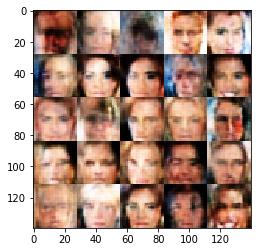

Epoch 1/1... Discriminator Loss: 0.261... Generator Loss: 2.921
Epoch 1/1... Discriminator Loss: 0.433... Generator Loss: 1.335
Epoch 1/1... Discriminator Loss: 0.323... Generator Loss: 2.908
Epoch 1/1... Discriminator Loss: 0.604... Generator Loss: 1.127
Epoch 1/1... Discriminator Loss: 0.224... Generator Loss: 2.718
Epoch 1/1... Discriminator Loss: 0.161... Generator Loss: 2.882
Epoch 1/1... Discriminator Loss: 0.734... Generator Loss: 2.235
Epoch 1/1... Discriminator Loss: 0.298... Generator Loss: 2.209
Epoch 1/1... Discriminator Loss: 0.459... Generator Loss: 2.917
Epoch 1/1... Discriminator Loss: 0.559... Generator Loss: 1.282


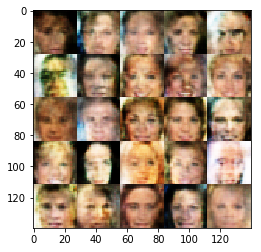

Epoch 1/1... Discriminator Loss: 0.737... Generator Loss: 1.512
Epoch 1/1... Discriminator Loss: 0.749... Generator Loss: 0.822
Epoch 1/1... Discriminator Loss: 0.218... Generator Loss: 3.755
Epoch 1/1... Discriminator Loss: 0.395... Generator Loss: 2.651
Epoch 1/1... Discriminator Loss: 0.398... Generator Loss: 1.452
Epoch 1/1... Discriminator Loss: 0.582... Generator Loss: 1.022
Epoch 1/1... Discriminator Loss: 0.549... Generator Loss: 1.164
Epoch 1/1... Discriminator Loss: 0.618... Generator Loss: 1.002
Epoch 1/1... Discriminator Loss: 0.361... Generator Loss: 1.542
Epoch 1/1... Discriminator Loss: 0.237... Generator Loss: 2.185


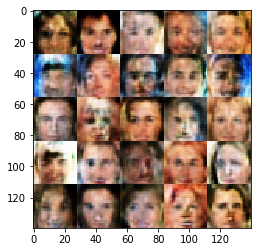

Epoch 1/1... Discriminator Loss: 0.159... Generator Loss: 2.991
Epoch 1/1... Discriminator Loss: 2.165... Generator Loss: 0.321
Epoch 1/1... Discriminator Loss: 0.665... Generator Loss: 2.116
Epoch 1/1... Discriminator Loss: 1.358... Generator Loss: 0.417
Epoch 1/1... Discriminator Loss: 1.155... Generator Loss: 0.683
Epoch 1/1... Discriminator Loss: 0.569... Generator Loss: 1.607
Epoch 1/1... Discriminator Loss: 0.355... Generator Loss: 1.577
Epoch 1/1... Discriminator Loss: 0.229... Generator Loss: 2.109
Epoch 1/1... Discriminator Loss: 0.471... Generator Loss: 2.690
Epoch 1/1... Discriminator Loss: 1.769... Generator Loss: 0.289


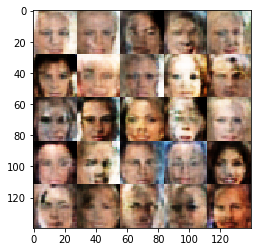

Epoch 1/1... Discriminator Loss: 0.418... Generator Loss: 2.206
Epoch 1/1... Discriminator Loss: 0.496... Generator Loss: 2.199
Epoch 1/1... Discriminator Loss: 0.836... Generator Loss: 0.868
Epoch 1/1... Discriminator Loss: 1.424... Generator Loss: 0.392
Epoch 1/1... Discriminator Loss: 0.998... Generator Loss: 2.057
Epoch 1/1... Discriminator Loss: 0.702... Generator Loss: 1.376
Epoch 1/1... Discriminator Loss: 0.702... Generator Loss: 2.292
Epoch 1/1... Discriminator Loss: 0.084... Generator Loss: 4.067
Epoch 1/1... Discriminator Loss: 0.172... Generator Loss: 3.051
Epoch 1/1... Discriminator Loss: 0.136... Generator Loss: 4.946


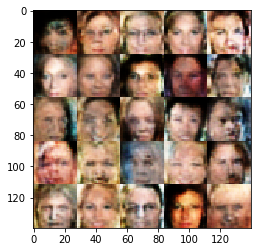

Epoch 1/1... Discriminator Loss: 1.431... Generator Loss: 0.469
Epoch 1/1... Discriminator Loss: 0.823... Generator Loss: 0.859
Epoch 1/1... Discriminator Loss: 0.594... Generator Loss: 1.164
Epoch 1/1... Discriminator Loss: 0.747... Generator Loss: 0.884
Epoch 1/1... Discriminator Loss: 1.018... Generator Loss: 1.289
Epoch 1/1... Discriminator Loss: 0.269... Generator Loss: 2.822
Epoch 1/1... Discriminator Loss: 0.119... Generator Loss: 2.868
Epoch 1/1... Discriminator Loss: 1.289... Generator Loss: 0.508


In [15]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.